In [1]:
import ap1
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
from scipy.stats import skew
from scipy.stats import kurtosis
import numpy as np

from sklearn import decomposition

In [2]:
import importlib
importlib.reload(ap1)

<module 'ap1' from '/Users/kritkorns/Mike/Jacob/AdvancedProject1/01_Lab/ap1.py'>

In [3]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

## Load Data

In [4]:
path = '/Users/kritkorns/Mike/Jacob/AdvancedProject1/01_Lab'
years = range(2012, 2021)
#years = range(2018, 2019)
df_freqs = {}

for year in years:
    file = '{}/dataset/Germany/{}.csv'.format(path,year)
    df_temp = pd.read_csv(file, parse_dates=['Datetime'])
    #df_temp['Datetime'] = pd.to_datetime(df_temp['Datetime'])
    df_freqs[year] = df_temp


In [5]:
df_freqs_all = pd.concat(df_freqs)
df_freqs_all = df_freqs_all.set_index('Datetime')
df_freqs_all

,Frequency,year,month,day,hour,minute,second
Datetime,,,,,,,
2012-01-01 00:00:00,NaN,2012,1,1,0,0,0
2012-01-01 00:00:01,NaN,2012,1,1,0,0,1
2012-01-01 00:00:02,NaN,2012,1,1,0,0,2
2012-01-01 00:00:03,NaN,2012,1,1,0,0,3
2012-01-01 00:00:04,NaN,2012,1,1,0,0,4
...,...,...,...,...,...,...,...
2020-09-30 23:59:55,20.0,2020,9,30,23,59,55
2020-09-30 23:59:56,22.0,2020,9,30,23,59,56
2020-09-30 23:59:57,24.0,2020,9,30,23,59,57


## Month aggregation data in each year

In [6]:
years = range(2012, 2021)
for year in years:
    df_freqs[year] = df_freqs[year].set_index('Datetime')['Frequency']

In [7]:
def groupData(df, by):
    """
        df :
         - DataFrame
        by : 
         - 'M' -> Month
         - 'D' -> Day
         - 'H' -> Hour
         - 'T' -> Minute
    """
    
    df_temp = df.copy()
    df_temp.index = df_temp.index.to_period(by)
    df_temp = df_temp.groupby(df_temp.index).mean()
    df_temp.index = df_temp.index.to_timestamp()
    
    return df_temp
    

## Distribution

In [14]:
def distributionValue(df):
    df_temp = df.copy()
    df_temp.dropna(inplace=True)
    a_dict = {}
    a_dict['mean'] = df_temp.mean()
    a_dict['median'] = df_temp.median()
    a_dict['std'] = df_temp.std()
    a_dict['skewness'] = skew(df_temp)
    a_dict['kurtosis'] = kurtosis(df_temp, fisher=False)

    return a_dict

def plotpdf(df, x, axe, bins=15, kde=True):
    df_temp = df.copy()
    def annotate(**kws):
        value = distributionValue(df_temp[x])
        bbox = dict(boxstyle="round,pad=0.3", alpha=0.3, fc="lightgrey", ec="grey", lw=1)
        annotate_value = (f"mean: {value['mean']:0.2f}\n"
                          f"std: {value['std']:0.2f}\n"
                          f"skew: {value['skewness']:0.2f}\n"
                          f"kurt: {value['kurtosis']:0.2f}")
        #ax = plt.gca()
        if value['skewness'] < 0:
            x_anotate = 0.05
        else:
            x_anotate = 0.7
        axe.annotate(annotate_value, xy=(x_anotate, .55), xycoords=axe.transAxes, fontsize=13, bbox=bbox)

    sns.histplot(df_temp, x=x, kde=kde, ax=axe, bins=bins)
    axe.set_title(x)
    axe.tick_params(axis='x', width=2, length=7, direction='inout', rotation=15, labelsize=13)
    axe.tick_params(axis='y', width=2, length=7, direction='inout', rotation=0, labelsize=13)
    axe.set(xlabel=None)
    axe.set(ylabel=None)
    plt.tight_layout()
    annotate()
    return axe


### Distribution for Germany's powergrid frequency for each year.

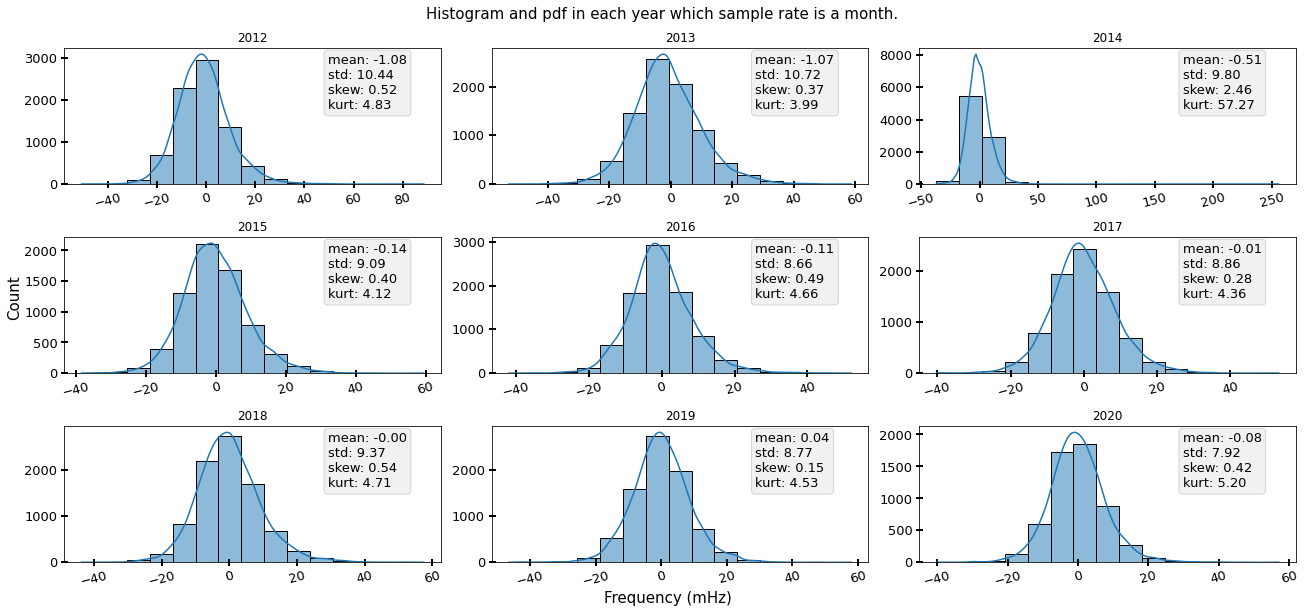

In [15]:
years = range(2012, 2021)
row_num = 3
col_num = int(len(years)/row_num)
years_reshape = np.array(years).reshape(row_num, col_num)

fig, ax = plt.subplots(row_num, col_num, figsize=(6*col_num, 2.8*row_num))
fig.suptitle('Histogram and pdf in each year which sample rate is a month.', size=15)

for i, row in enumerate(years_reshape):
    for j, year in enumerate(row):
        try:
            df_temp = pd.DataFrame(groupData(df_freqs[year], 'H'))
            plotpdf(df_temp, 'Frequency', ax[i][j])
            ax[i][j].set_title(str(int(year)))
        except:
            pass

fig.text(0.505, -0.005, 'Frequency (mHz)', ha='center', fontsize=15)
fig.text(-0.005, 0.500, 'Count', va='center', rotation='vertical', fontsize=15)
plt.tight_layout(h_pad=1, w_pad=1)
plt.show()

## Correlation Scatter Plots

### Pearson Scatter Plots

In [76]:
def correlation(x, y, **kws):
    corr_pearson, p_value_pearson = stats.pearsonr(x, y)
    corr_spearman, p_value_spearman = stats.spearmanr(x, y)
    corr_kendal, p_value_kendal = stats.kendalltau(x, y)
    bbox = dict(boxstyle="round,pad=0.3", alpha=0.3, fc="lightgrey", ec="grey", lw=1)
    annotate_value = (f"Pearson: {corr_pearson:0.2f}\n"
                      f"Spearman: {corr_spearman:0.2f}\n"
                      f"Kendall: {corr_kendal:0.2f}")
    axe = plt.gca()
    axe.annotate(annotate_value, xy=(.6, .5), xycoords=axe.transAxes, fontsize=12, bbox=bbox)


In [17]:
#df_filter = df_freqs_all.groupby(['year','month','day'], as_index=False).mean()
df_filter = pd.DataFrame(groupData(df_freqs_all, 'H'))
df_filter = df_filter.astype({'year': 'int32', 'month': 'int32', 'day': 'int32', 'hour': 'int32'})
df_filter.dropna(inplace=True)
display(df_filter.head(5))


,Frequency,year,month,day,hour,minute,second
Datetime,,,,,,,
2012-02-01 00:00:00,-0.876531,2012.0,2.0,1.0,0.0,29.5,29.5
2012-02-01 01:00:00,-2.282274,2012.0,2.0,1.0,1.0,29.5,29.5
2012-02-01 02:00:00,-2.319862,2012.0,2.0,1.0,2.0,29.5,29.5
2012-02-01 03:00:00,4.165770,2012.0,2.0,1.0,3.0,29.5,29.5
2012-02-01 04:00:00,2.367019,2012.0,2.0,1.0,4.0,29.5,29.5


### Correlation Scatter Plots for every year

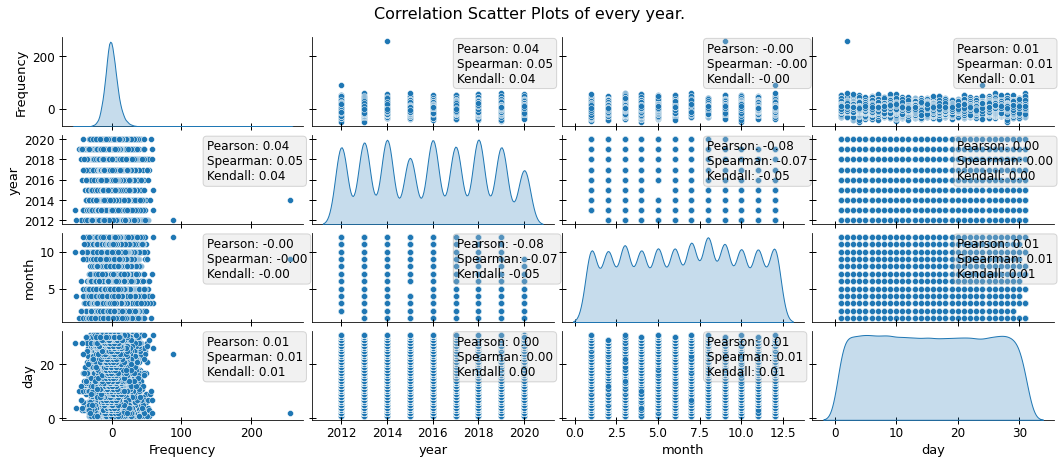

In [82]:
columns = ['Frequency', 'year', 'month' , 'day']
g = sns.pairplot(df_filter,
                 vars=columns,
                 diag_kind="kde", height=1.5, aspect=2.5)
g.map_offdiag(correlation)
g.fig.suptitle('Correlation Scatter Plots of every year.', size=16, y=1.05)

for i, column_y in enumerate(columns):
    for j, column_x in enumerate(columns):
        axe = g.axes[i,j]
        if column_y == 'year':
            y_tick = range(2012, 2021, 2)
            axe.set_yticks(y_tick)
            axe.set_yticklabels(y_tick)
            axe.set_visible(True)
        axe.tick_params(axis='x', width=1, length=7, direction='inout', rotation=0, labelsize=12)
        axe.tick_params(axis='y', width=1, length=7, direction='inout', rotation=0, labelsize=12)
        axe.set_ylabel(column_y, size=13)
        axe.set_xlabel(column_x, size=13)

plt.show()

It appears that the range of frequency is between -50 and 50 mHz throughout the years.

### Correlation Scatter Plots for each year

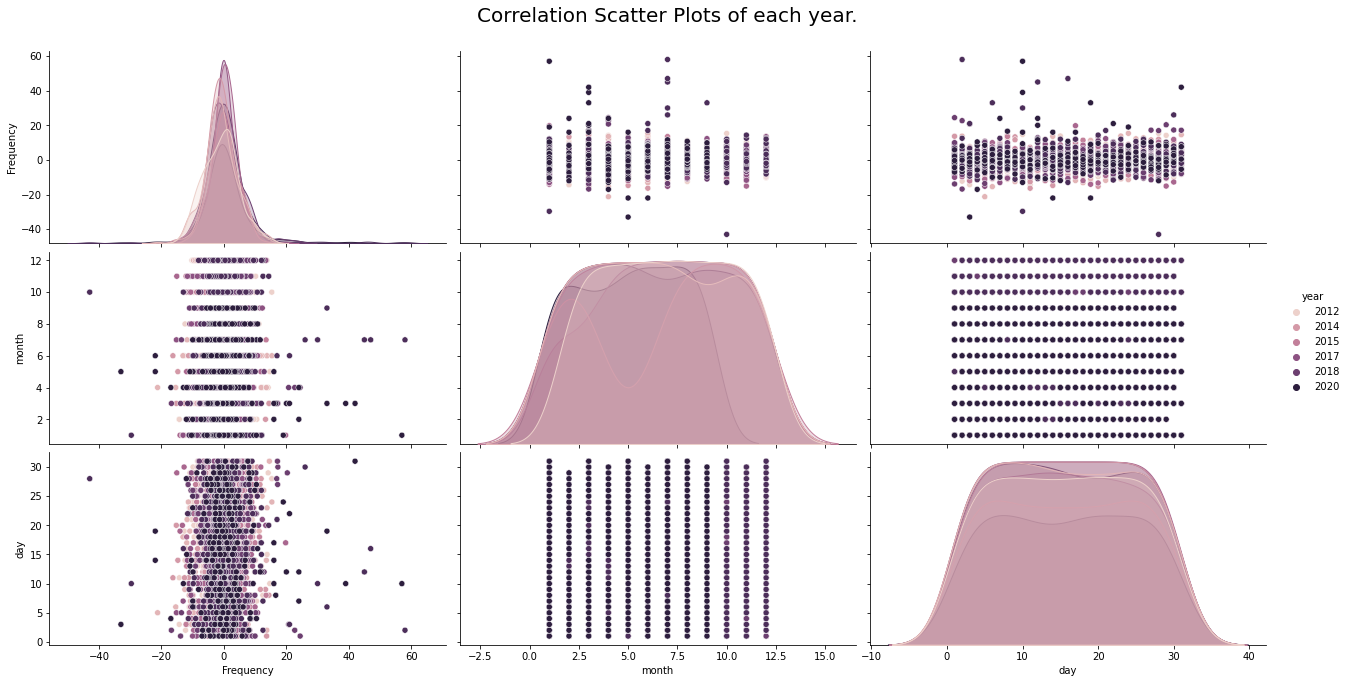

In [11]:
g = sns.pairplot(df_filter,
                 vars=['Frequency', 'month' , 'day'],
                 diag_kind="kde", height=3, aspect=2, hue='year')
#_ = g.map_offdiag(corrfunc)
_ = g.fig.suptitle('Correlation Scatter Plots of each year.', size=20, y=1.05)


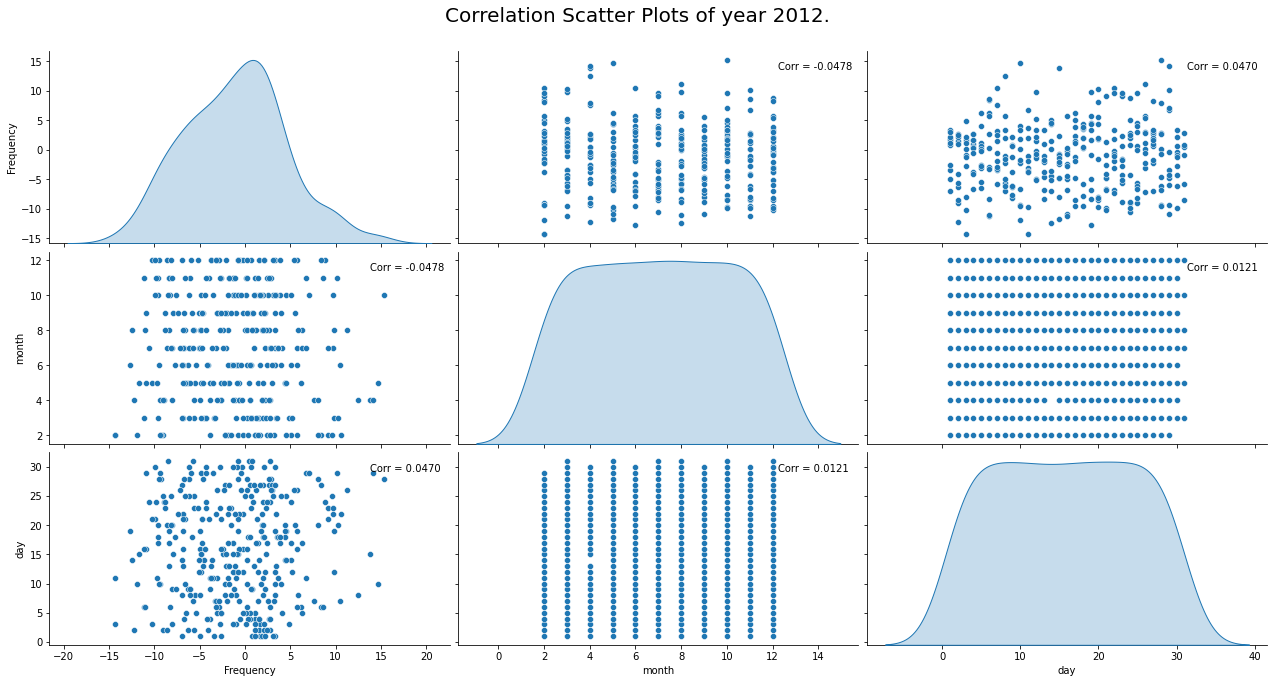

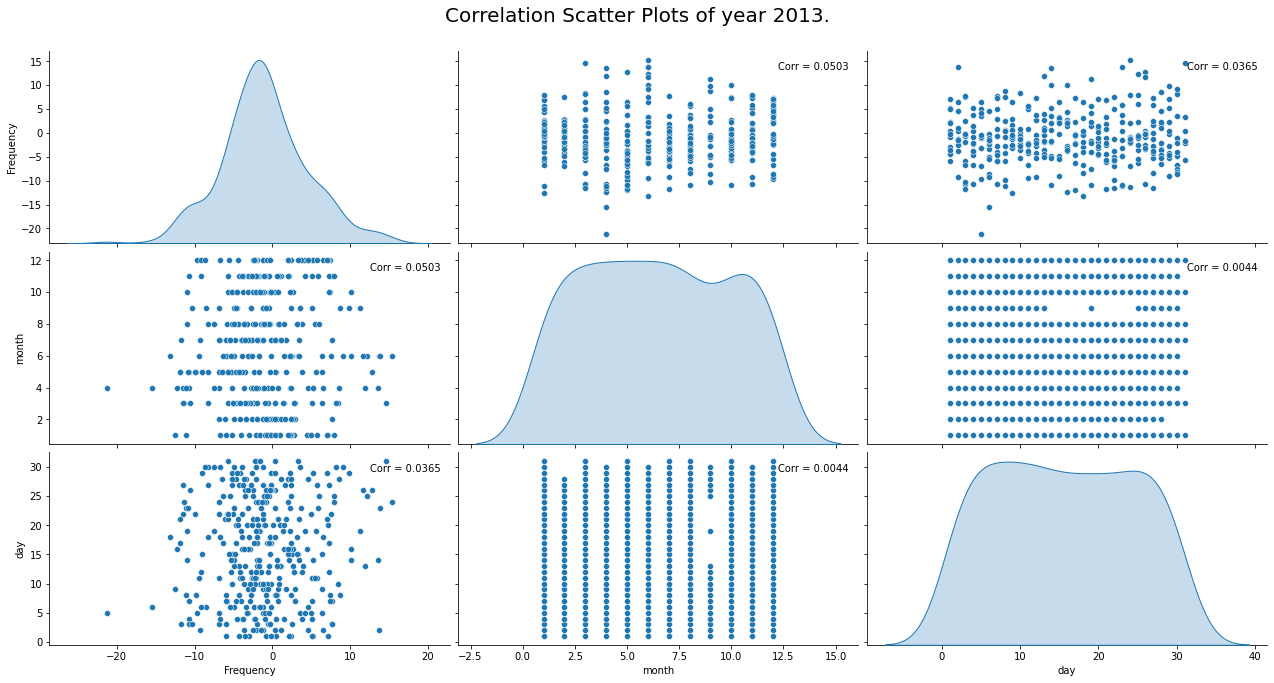

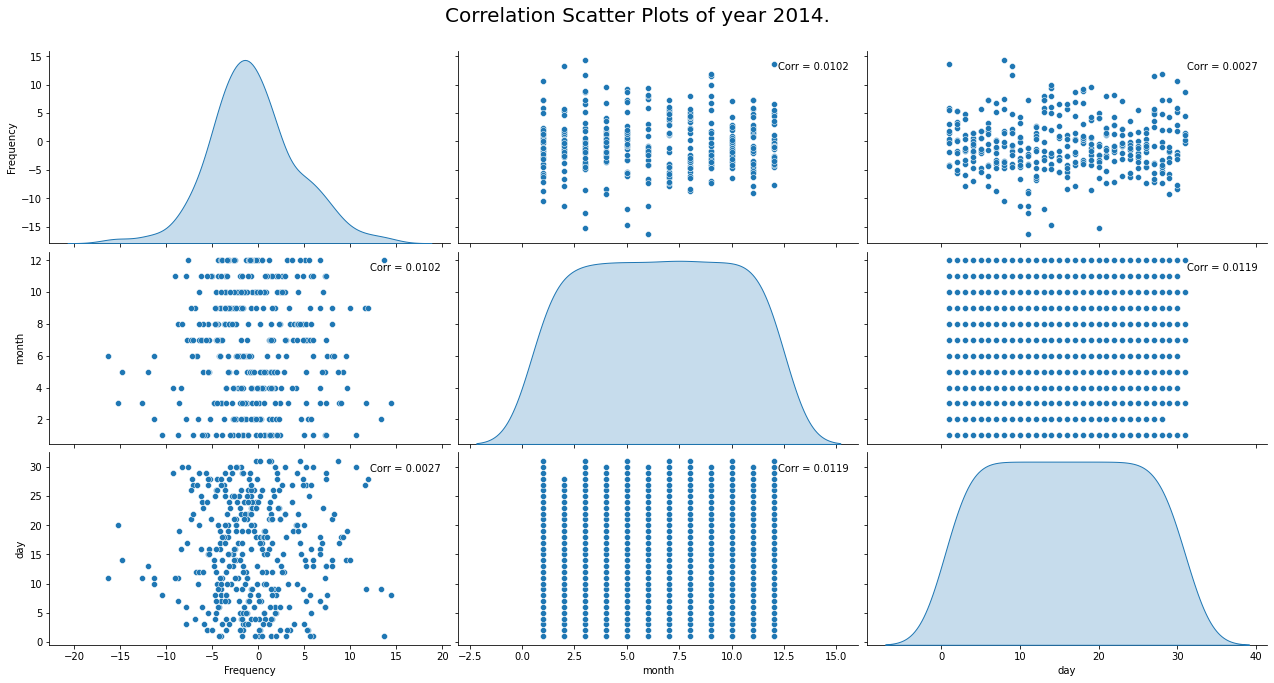

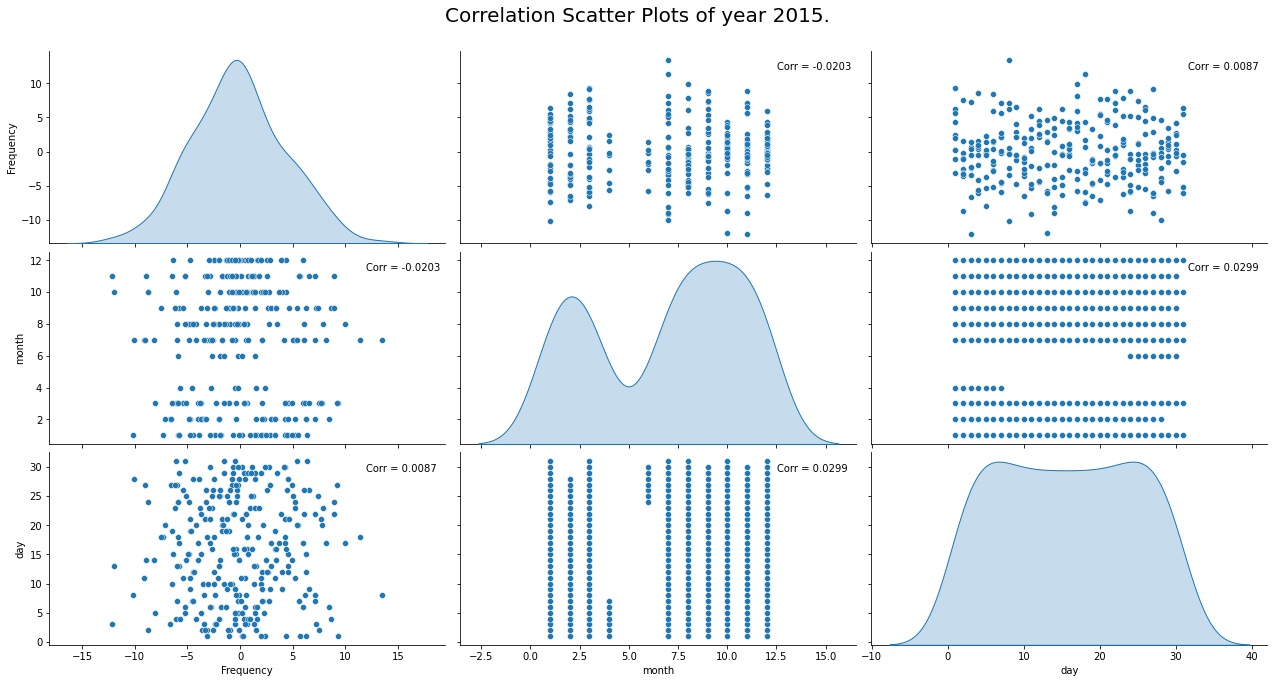

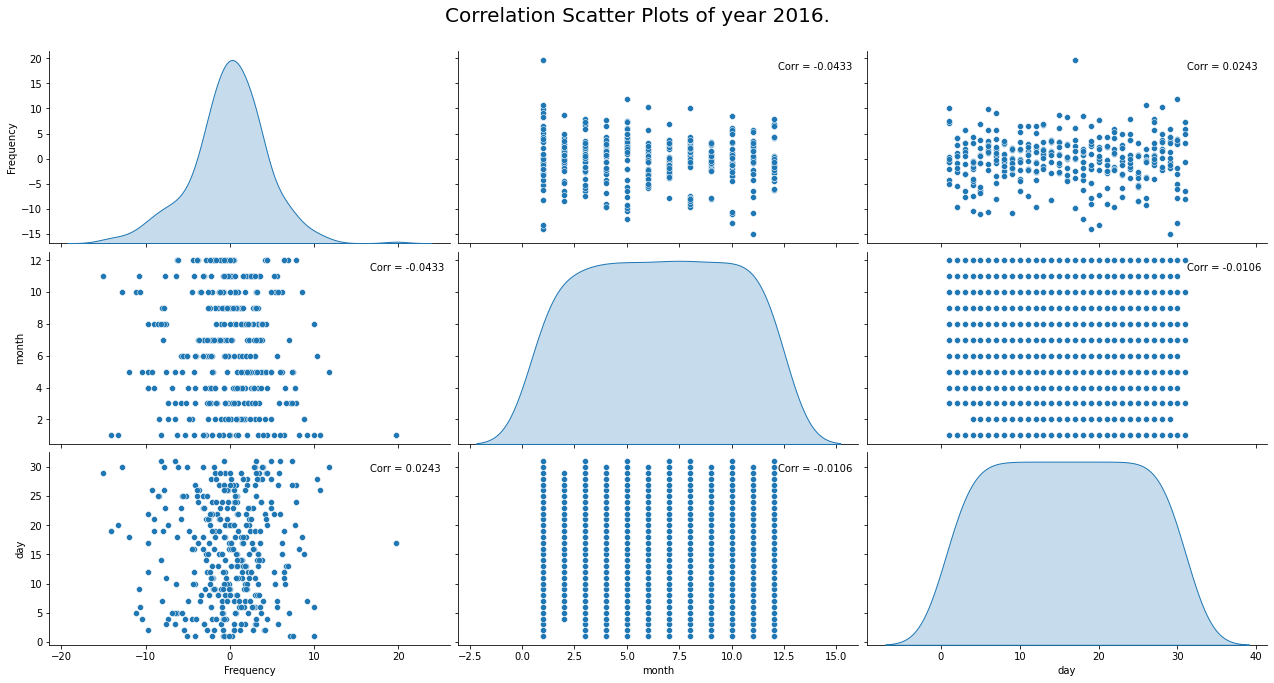

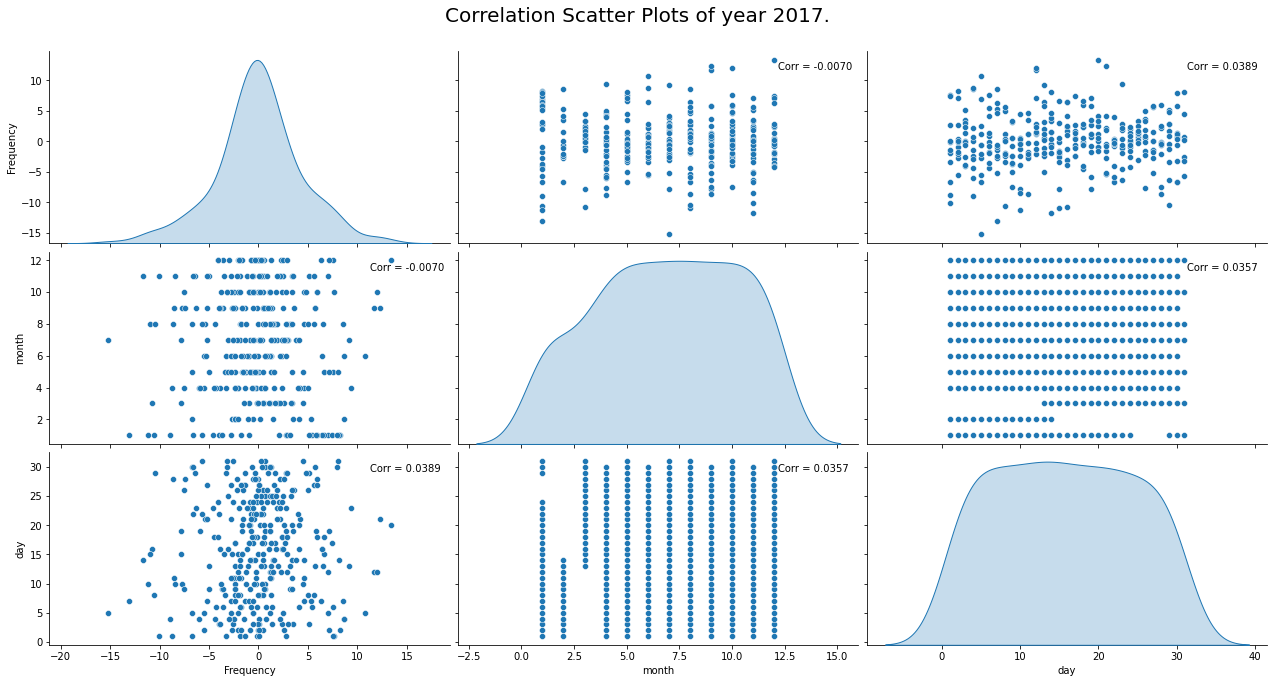

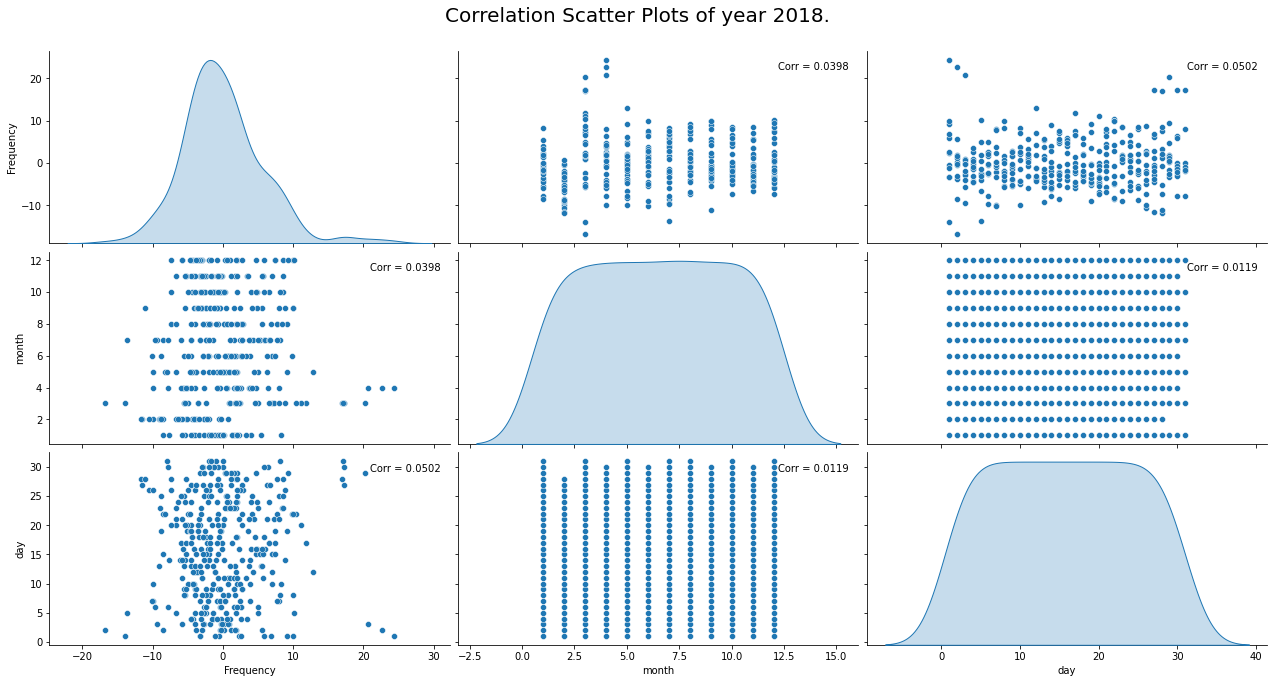

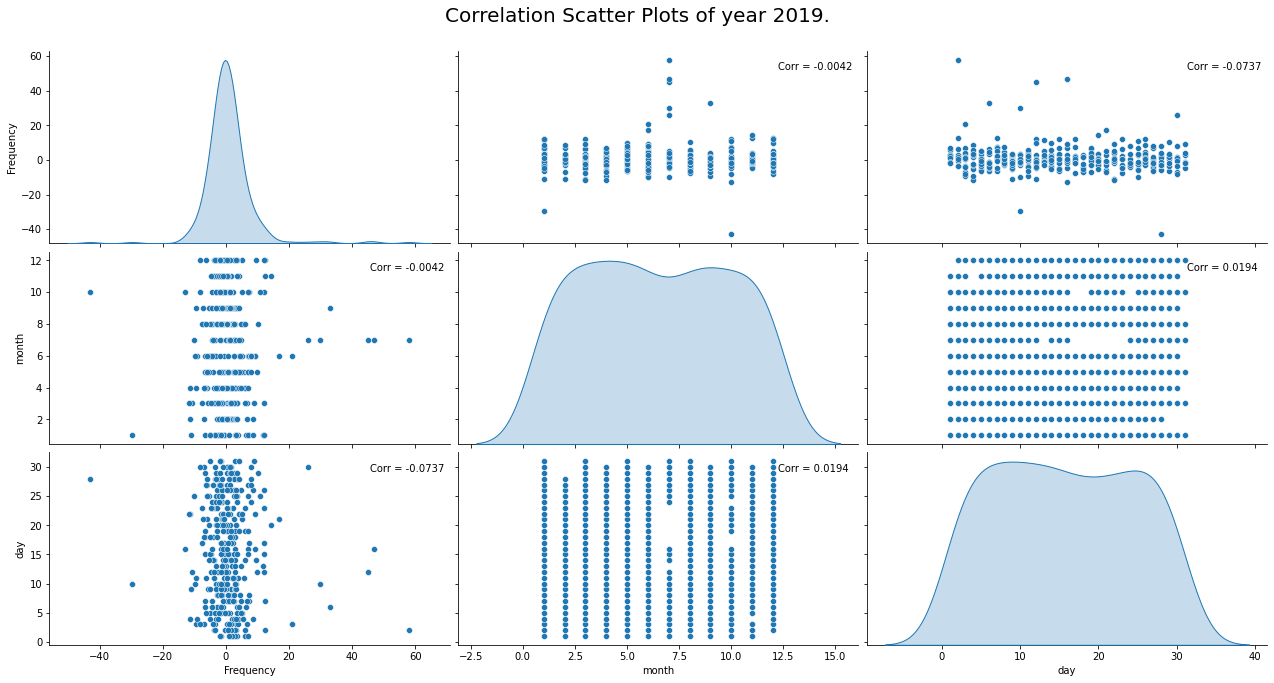

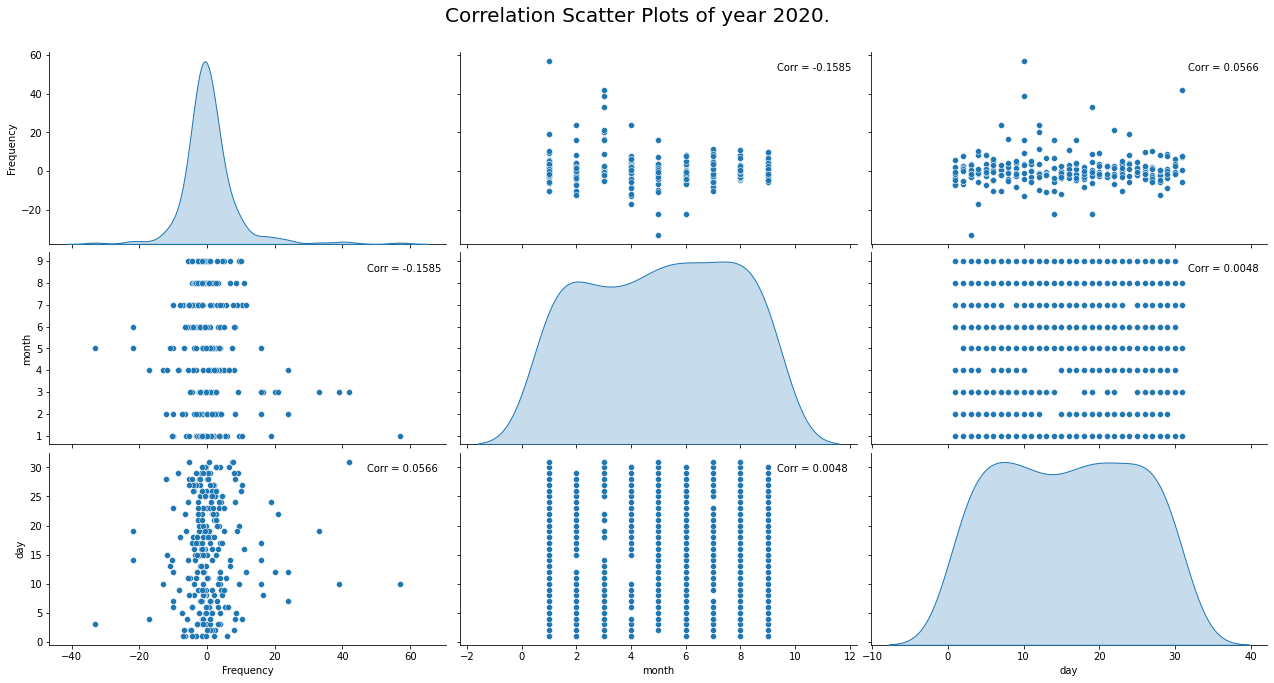

In [12]:
for year in years:
    g = sns.pairplot(df_filter[df_filter['year']==year],
                     vars=['Frequency', 'month' , 'day'],
                     diag_kind="kde", height=3, aspect=2)
    _ = g.map_offdiag(corrfunc)
    _ = g.fig.suptitle('Correlation Scatter Plots of year {}.'.format(year), 
                       size=20, y=1.05)



## PCA (Find lowest 2 Empirical Orthogonal Functions)

In [83]:
df_filter.head()

,Frequency,year,month,day,hour,minute,second
Datetime,,,,,,,
2012-02-01 00:00:00,-0.876531,2012,2,1,0,29.5,29.5
2012-02-01 01:00:00,-2.282274,2012,2,1,1,29.5,29.5
2012-02-01 02:00:00,-2.319862,2012,2,1,2,29.5,29.5
2012-02-01 03:00:00,4.165770,2012,2,1,3,29.5,29.5
2012-02-01 04:00:00,2.367019,2012,2,1,4,29.5,29.5


In [119]:
class findPCA():
    def __init__(self, df, n, column):
        if isinstance(df, pd.Series):
            # Just duplicate the column
            df = pd.DataFrame(df)
            df_temp = df.copy()
            df = df.join(df_temp, how='left', rsuffix='_copy')
            self.df = df.copy()
        else:
            self.df = df.copy()
        self.n = n
        self.column = column
        
    def values(self): 
        pca = decomposition.PCA(n_components=self.n)
        
        # Get PCs
        index = self.df.index
        df_pcs = pca.fit_transform(self.df)
        self.pcs = pd.DataFrame(data = df_pcs,
                                columns = [f"PC{i+1}" for i in range(self.n)],
                                index=index)
        
        # Get variance fraction
        self.evfs = pca.explained_variance_ratio_*100
        
        return self.pcs, self.evfs
        
    def plot(self, figsize=(15,6)):
        self.values()
        
        row_num = self.n+1
        col_num = 1

        fig, axe = plt.subplots(row_num, col_num, figsize=figsize, sharex=True, sharey=True)
        fig.suptitle(f"A diagram for Principal Component "
                     f"Analysis (PCA) with {self.n} components.", size=16)

        self.df[self.column].plot(ax=axe[0], legend=False)
        axe[0].set_ylabel(f"{self.column}\n(mHz)", x=-0.05)
        axe[0].tick_params(axis='x', width=2, length=7, direction='inout', rotation=15, labelsize=13)
        axe[0].tick_params(axis='y', width=2, length=7, direction='inout', rotation=0, labelsize=13)
        axe[0].grid()
        
        for i in range(1, row_num):
            pc = self.pcs[f"PC{i}"]
            evf = self.evfs[i-1]
            
            axe[i].plot(pc, label=f"Variance Ratio: {evf:.2f}%")
            axe[i].set_ylabel(f"PC{i}\n(mHz)", x=-0.05, size=13)
            axe[i].grid(which='both')
            axe[i].legend(loc='best', fontsize='large', 
                          fancybox=True, framealpha=0.7,
                          handlelength=0, handletextpad=0)
            axe[i].set_xlabel("Datetime (year)", size=13)
            axe[i].tick_params(axis='x', width=2, length=7, direction='inout', rotation=15, labelsize=13)
            axe[i].tick_params(axis='y', width=2, length=7, direction='inout', rotation=0, labelsize=13)
        plt.tight_layout()
        plt.show()


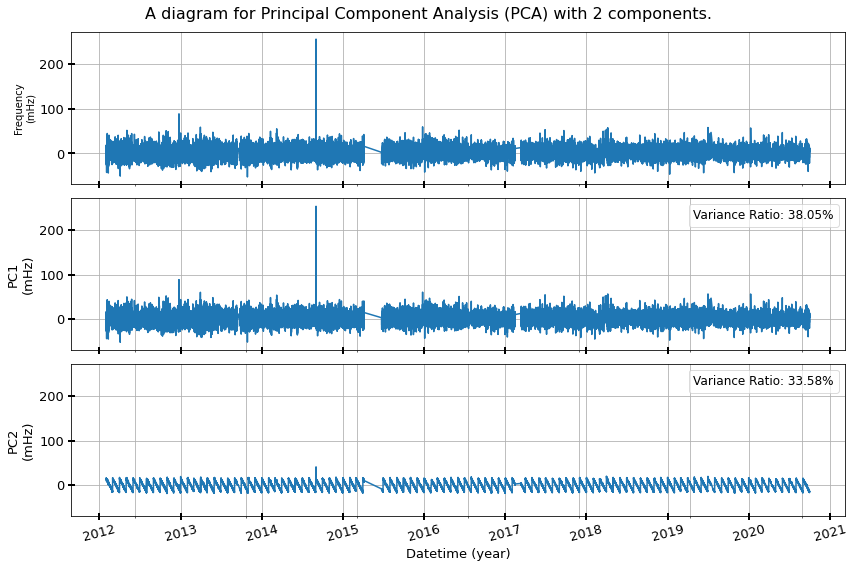

In [120]:
df_temp = df_filter[['Frequency', 'year', 'month', 'day', 'hour']]

n = 2
pca = findPCA(df_temp, n, 'Frequency')
pca.plot(figsize=(12, 4*n))


From the PCA diagram, I found that PC1 and PC2 carry respectively 38.05% and 33.58% of the variance of the input data. We can also see the pattern for PC2. the second component

    Once this first pattern is identified, another pattern is identified, capturing the greatest amount of the remaining temporal variability not already captured by the previous pattern(s).Footnote 3 While this is a statistical construct, we hope that the mechanisms driving the phenomenon being examined may have a unique signature that is captured by this methodology – here identified as a pattern that varies in time the same way in each time series in the dataset. Each of the patterns identified has an associated time series showing how the amplitude of the pattern changes in time, known as principal 

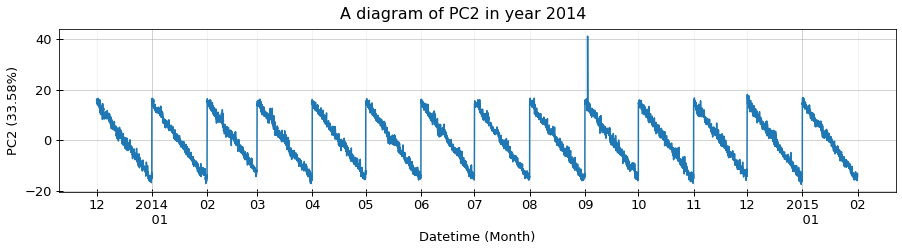

In [123]:
import matplotlib

pcs, evfs = pca.values()
pcs_temp = pcs.loc["2013-12-01 00:00:00":"2015-01-31 23:00:00"]

fig, axe = plt.subplots(figsize=(15, 3))
fig.suptitle(f"A diagram of PC2 in year 2014", size=16)

axe.plot(pcs_temp['PC2'])
axe.set_ylabel(f"PC2 ({evfs[1]:.2f}%)", size=13)
axe.set_xlabel("Datetime (Month)", size=13)
axe.xaxis.set_major_locator(matplotlib.dates.YearLocator())
axe.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y\n    %m"))
axe.xaxis.set_minor_locator(matplotlib.dates.MonthLocator())
axe.xaxis.set_minor_formatter(matplotlib.dates.DateFormatter("%m"))
axe.grid(which='major', alpha=0.7)
axe.grid(which='minor', alpha=0.2)
axe.tick_params(axis='x', which='major', width=1, length=7, direction='inout', rotation=0, labelsize=13)
axe.tick_params(axis='y', which='major', width=1, length=7, direction='inout', rotation=0, labelsize=13)
axe.tick_params(axis='x', which='minor', width=1, length=7, direction='inout', rotation=0, labelsize=13)
axe.tick_params(axis='y', which='minor', width=1, length=7, direction='inout', rotation=0, labelsize=13)

plt.show()

## Increment Statistics

In [124]:
df_freqs_all['Frequency_inc'] = df_freqs_all['Frequency'].diff()
df_freqs_all

,Frequency,year,month,day,hour,minute,second,Frequency_inc
Datetime,,,,,,,,
2012-01-01 00:00:00,NaN,2012,1,1,0,0,0,NaN
2012-01-01 00:00:01,NaN,2012,1,1,0,0,1,NaN
2012-01-01 00:00:02,NaN,2012,1,1,0,0,2,NaN
2012-01-01 00:00:03,NaN,2012,1,1,0,0,3,NaN
2012-01-01 00:00:04,NaN,2012,1,1,0,0,4,NaN
...,...,...,...,...,...,...,...,...
2020-09-30 23:59:55,20.0,2020,9,30,23,59,55,2.0
2020-09-30 23:59:56,22.0,2020,9,30,23,59,56,2.0
2020-09-30 23:59:57,24.0,2020,9,30,23,59,57,2.0


## Increment Statistics of every year (2012-2020) with the interval of 60 seconds.

In [125]:
df_temp = df_freqs_all[['Frequency', 'Frequency_inc', 'minute', 'second']]
df_temp = df_temp.groupby(['minute','second'], as_index=False).mean()
df_temp

,minute,second,Frequency,Frequency_inc
0,0,0,9.679741,-0.047135
1,0,1,9.586500,-0.095956
2,0,2,9.207266,-0.377594
3,0,3,8.597242,-0.610762
4,0,4,7.853247,-0.739712
...,...,...,...,...
3595,59,55,9.626394,0.018013
3596,59,56,9.650963,0.028505
3597,59,57,9.704875,0.048881
3598,59,58,9.738558,0.033780


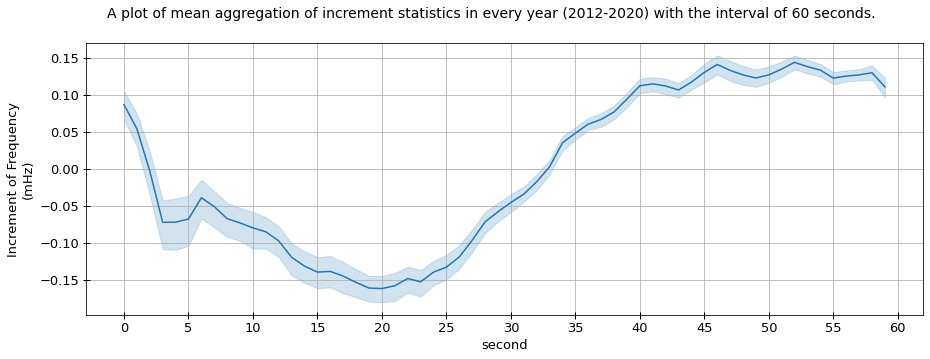

In [131]:
fig, axe = plt.subplots(figsize=(15, 5))
fig.suptitle('A plot of mean aggregation of increment statistics '
             'in every year (2012-2020) with the interval of 60 seconds.', size=14)

column = 'second'
_ = sns.lineplot(data=df_temp, x=column, y='Frequency_inc', ax=axe)
axe.set_xlabel(column, size=13)
axe.set_ylabel("Increment of Frequency\n(mHz)", size=13)
axe.set_xticks(range(0, 61, 5))
axe.tick_params(axis='x', which='major', width=1, length=7, direction='inout', rotation=0, labelsize=13)
axe.tick_params(axis='y', which='major', width=1, length=7, direction='inout', rotation=0, labelsize=13)
axe.grid()
plt.show()

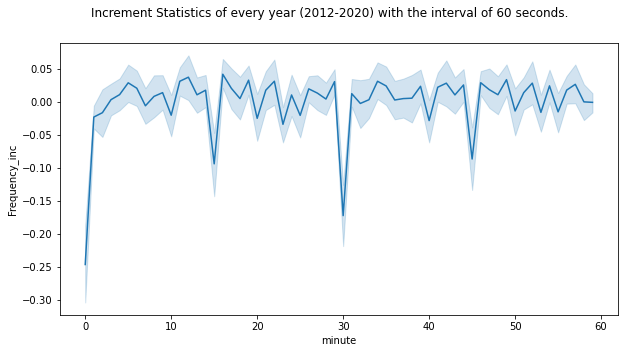

In [11]:
fig, axe = plt.subplots(figsize=(10, 5))
fig.suptitle('Increment Statistics of every year (2012-2020) with the interval of 60 seconds.')

_ = sns.lineplot(data=df_temp, x='minute', y='Frequency_inc', ax=axe)

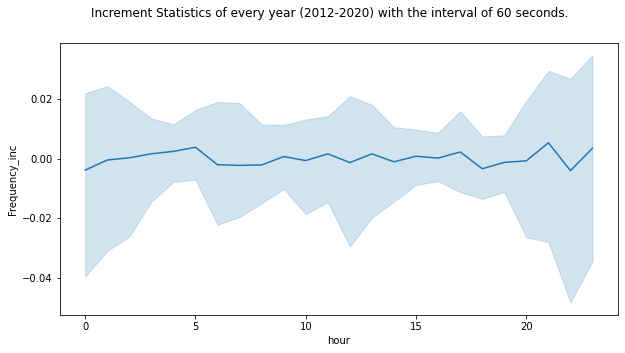

In [13]:
df_temp = df_freqs_all[['Frequency', 'Frequency_inc', 'hour', 'minute']]
df_temp = df_temp.groupby(['hour', 'minute'], as_index=False).mean()
df_temp

fig, axe = plt.subplots(figsize=(10, 5))
fig.suptitle('Increment Statistics of every year (2012-2020) with the interval of 60 seconds.')

_ = sns.lineplot(data=df_temp, x='hour', y='Frequency_inc', ax=axe)

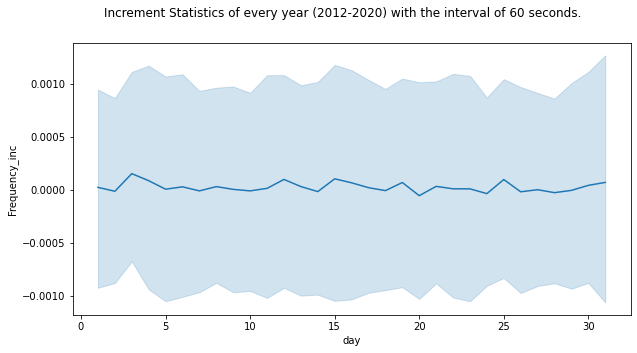

In [14]:
df_temp = df_freqs_all[['Frequency', 'Frequency_inc', 'hour', 'day']]
df_temp = df_temp.groupby(['hour', 'day'], as_index=False).mean()
df_temp

fig, axe = plt.subplots(figsize=(10, 5))
fig.suptitle('Increment Statistics of every year (2012-2020) with the interval of 60 seconds.')

_ = sns.lineplot(data=df_temp, x='day', y='Frequency_inc', ax=axe)

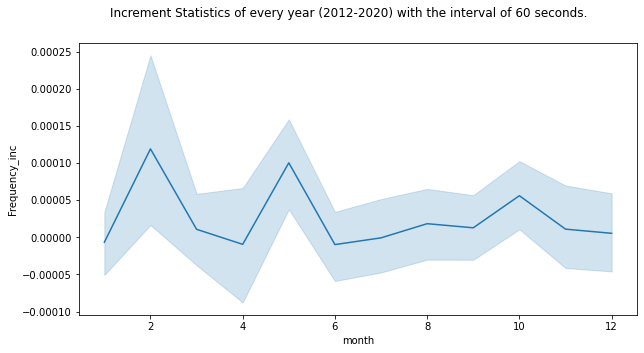

In [16]:
df_temp = df_freqs_all[['Frequency', 'Frequency_inc', 'month', 'day']]
df_temp = df_temp.groupby(['month', 'day'], as_index=False).mean()
df_temp

fig, axe = plt.subplots(figsize=(10, 5))
fig.suptitle('Increment Statistics of every year (2012-2020) with the interval of 60 seconds.')

_ = sns.lineplot(data=df_temp, x='month', y='Frequency_inc', ax=axe)

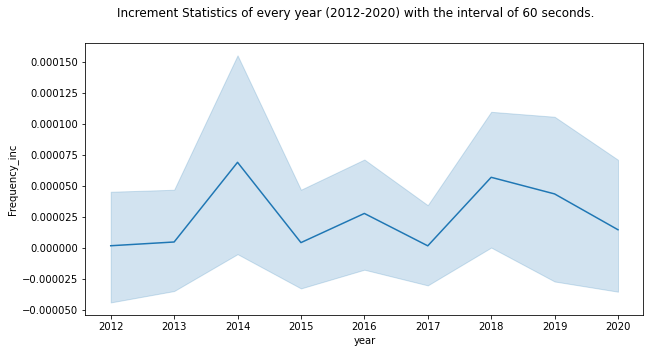

In [17]:
df_temp = df_freqs_all[['Frequency', 'Frequency_inc', 'year', 'day']]
df_temp = df_temp.groupby(['year', 'day'], as_index=False).mean()
df_temp

fig, axe = plt.subplots(figsize=(10, 5))
fig.suptitle('Increment Statistics of every year (2012-2020) with the interval of 60 seconds.')

_ = sns.lineplot(data=df_temp, x='year', y='Frequency_inc', ax=axe)

In [262]:
df_temp = df_freqs_all[['Frequency', 'Frequency_inc', 'minute', 'second']]
df_temp = df_temp.groupby(['minute','second'], as_index=False).mean()
df_temp

,minute,second,Frequency,year,month,day,hour,Frequency_inc
0,0,0,9.679741,2015.884856,6.392991,15.729662,11.5,-0.047135
1,0,1,9.586500,2015.884856,6.392991,15.729662,11.5,-0.095956
2,0,2,9.207266,2015.884856,6.392991,15.729662,11.5,-0.377594
3,0,3,8.597242,2015.884856,6.392991,15.729662,11.5,-0.610762
4,0,4,7.853247,2015.884856,6.392991,15.729662,11.5,-0.739712
...,...,...,...,...,...,...,...,...
3595,59,55,9.626394,2015.884856,6.392991,15.729662,11.5,0.018013
3596,59,56,9.650963,2015.884856,6.392991,15.729662,11.5,0.028505
3597,59,57,9.704875,2015.884856,6.392991,15.729662,11.5,0.048881
3598,59,58,9.738558,2015.884856,6.392991,15.729662,11.5,0.033780


## Lineplot of frequency with the interval of 60 seconds from 2012-2020.

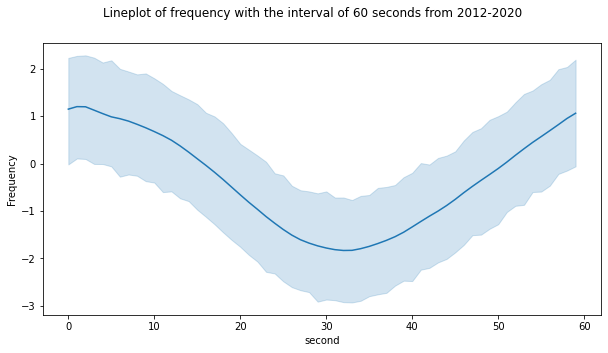

In [43]:
fig, axes = plt.subplots(figsize=(10, 5), sharex=True)
fig.suptitle('Lineplot of frequency with the interval of 60 seconds from 2012-2020')

_ = sns.lineplot(data=df_temp, x='second', y='Frequency')


In [46]:
df_temp2 = df_freqs_all[['Frequency', 'Frequency_inc', 'year', 'month']]
df_temp2 = df_temp2.groupby(['year','month'], as_index=False).mean()
df_temp2

,year,month,Frequency,Frequency_inc
0,2012,1,NaN,NaN
1,2012,2,-0.189983,-0.000017
2,2012,3,-0.632876,0.000036
3,2012,4,-0.044192,-0.000020
4,2012,5,-1.800107,0.000027
...,...,...,...,...
100,2020,5,-0.147372,0.000100
101,2020,6,-0.553080,-0.000175
102,2020,7,-0.243988,0.000032
103,2020,8,0.046945,-0.000006


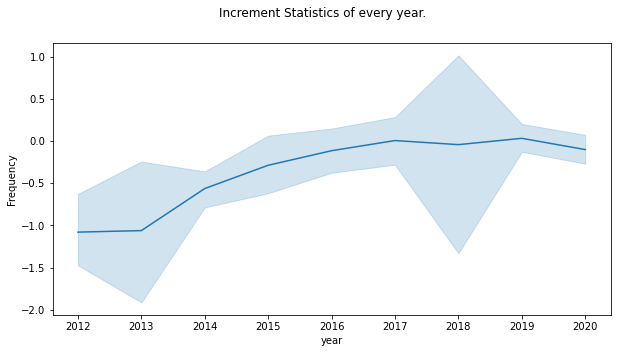

In [47]:
fig, axes = plt.subplots(figsize=(10, 5), sharex=True)
fig.suptitle('Increment Statistics of every year.')

_ = sns.lineplot(data=df_temp2, x='year', y='Frequency')
